# Visitor Prediction for the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan (fi007)
- Patryk Gadziomski (pg058)

<div style="width: 100%; height: 30px; background-color:red"></div>

**Project description:**

For the project in "Selected Topics of AI" we decided to make a visitor forecast for the BWI library (library of the Institute of Business Administration) at the University of Stuttgart.


In the BWI library, the number of visitors is recorded every day (Monday - Friday). This is done in the form of "visitor statistics". In the visitor statistics, visitors are recorded in eight different time periods: `09:30`, `10:45`, `13:45`, `16:15`, `17:45`, `18:00`, `18:30` and `18:45`. Due to the library's opening hours (Mon. - Thurs. 09:00-19:00; Fri. 09:00 - 17:00), the last three time periods are not recorded on Fridays.


**Data:** Visitor statistics from the BWI library, which are available in analogue form. Since the data is recorded by hand on paper, the data must be digitized for the first time. This is done by manually filling in a pre-generated Excel table (see `data/dataset_creator.ipynb`).

**Goal:** The goal of this project, and the AI model, is to predict the number of visitors for the coming day.

**Method:** To achieve the goal, an LSTM model is trained and fine-tuned.

<figure>
    <img 
    src="./img/workflow.png" 
    width="700px"
    alt='Visitor Prediction Project Workflow'
    >
</figure>
<p>Source: own creation (Patryk Gadziomski)</p>

## 0. Import Requirements and set the device

In the following step, all necessary libraries for the project are imported.

In [785]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from meteostat import Point, Daily
import holidays
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc

The GPU is used to execute the model and for training. If this is not available, the CPU is used instead.

In [786]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Data Exploration

In this step, the data is loaded and examined in more detail.
The data is self-collected data from the BWI library of the University of Stuttgart. These represent the number of visitors to the BWI library.

At first glance, it is clear that the data contains a large number of "missing values".

These must be filled in in the next steps.

In [787]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/bwi_library_visitor_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


Using the `info()` function, the missing values are emphasized again by the difference in the count values.

You can also see that the feature `timestemp` is of the type `datetime64`, which cannot be transferred to a model input in this way.

In [788]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In order to have a fixed number that represents the number of missing values, the `isnull()` function is used and added up. The result is the number of missing values in `visitor_data`.

In [789]:
visitor_data.isnull().sum()

timestemp       0
value        1114
dtype: int64

With the `describe()`-function, you get an overview of the earliest and the last recorded date (`min` and `max`). The other values of the date are not important. The `value` values are of no use due to the many missing values. This will change after preprocessing.

In [790]:
visitor_data.describe()

,value
count,3782.000000
mean,2.870968
std,3.526116
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,20.000000


The following figure shows the progression of visitor numbers over time. The missing values already mentioned can also be seen. A larger gap can also be seen in the December-January period. This indicates the winter vacations.

<Axes: xlabel='timestemp'>

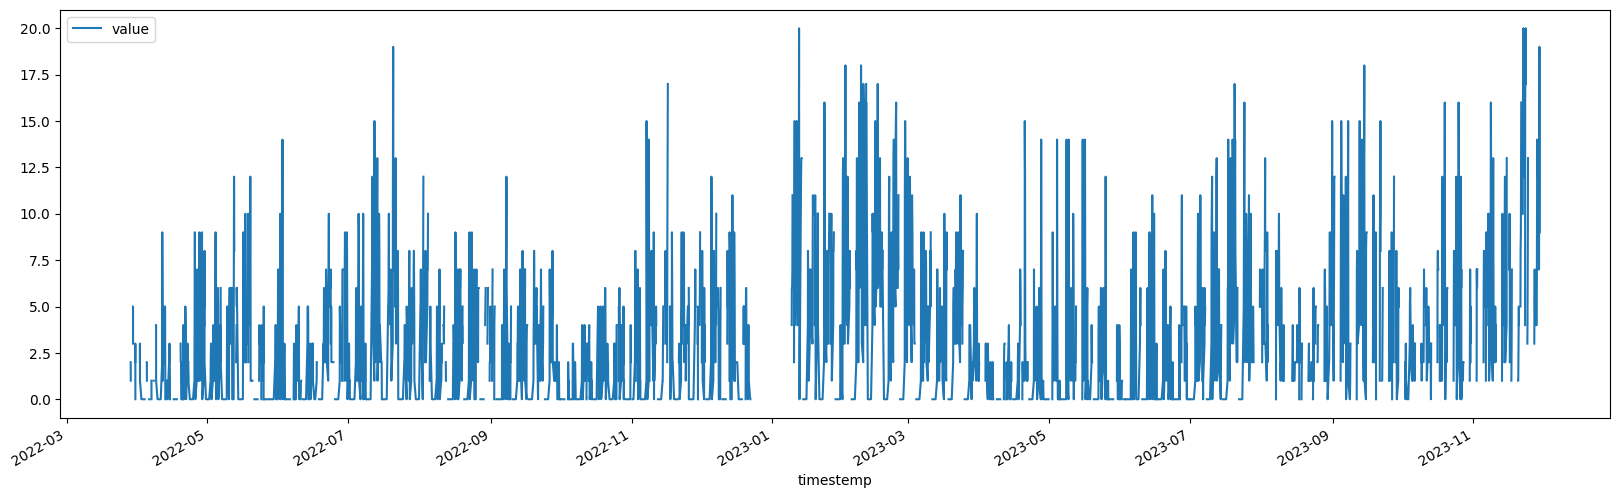

In [791]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 2. Data Preprocessing

The preprocessing step is about filling in the missing values.
To fill in the missing values, the `backfill` method is used, which fills in the missing values based on the past values.

In addition to the `backfill` method, the `interpolate()`, `backfill(limit=7)` and `forward()` methods were also tried.

The best results were obtained using the `backfill` method without `limit`.



In the old Notebokk the command:

`visitor_data = visitor_data['value'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)`

is used. However, this is outdated and would cause errors in future pandas versions. For this reason, it has been replaced by the updated command:

`visitor_data['value'] = visitor_data['value'].bfill(axis=None)`

In [792]:
# Missing Values Handling
visitor_data['value'] = visitor_data['value'].bfill(axis=None)

The following figure shows the progression of visitor numbers over time, after preprocessing and therefore without missing values.

<Axes: xlabel='timestemp'>

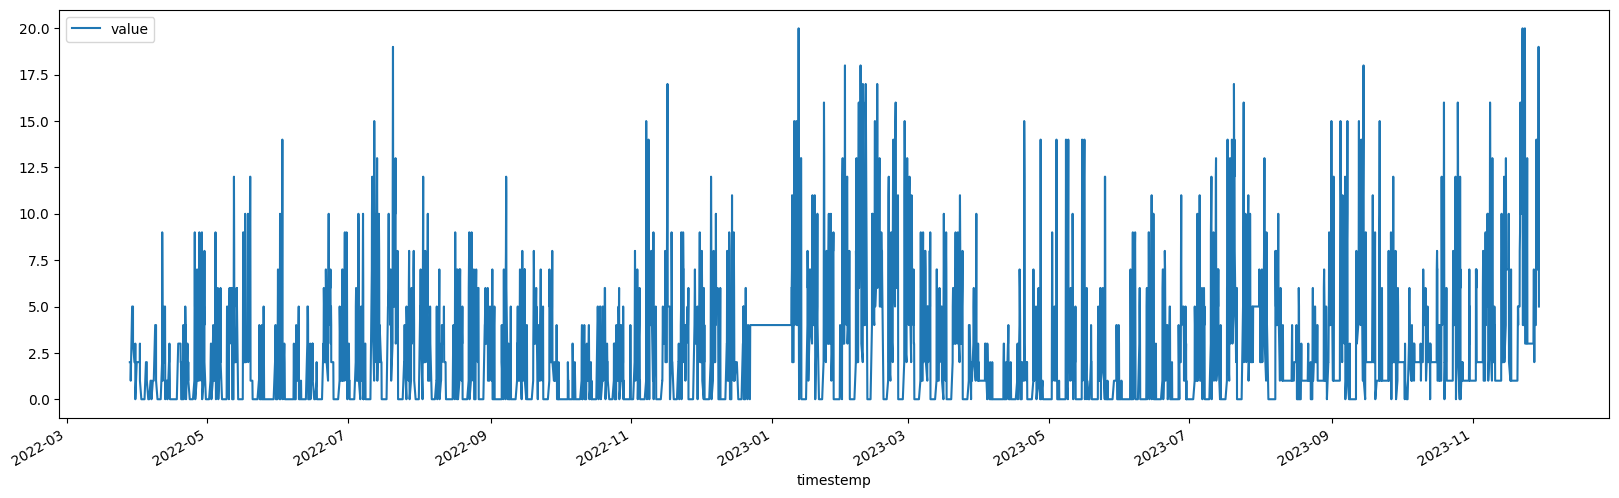

In [793]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 3. Feature Selection and further Preprocessing

Further features are extracted using the existing features ("timestemp"):

- Date: The calendar date
- Weekday: Regular visitor patterns can be identified by the day of the week
- Weekend: The library is closed at weekends, so there will be no record of visitors
- Exam periods: During examination periods, there can be an increase in library use as students study and prepare for their exams
- Holiday: During the holidays, the library is closed
- Weather data: Weather conditions can have an impact on a student's decision to visit the library, with adverse weather conditions potentially leading to a reduction in footfall
- t-1 Sequences: Historical data can provide context. The sequences containing the values for the last two weeks are created for input into the LSTM model

In [794]:
# Extract the date
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list
visitor_data.head()

,timestemp,value,date
0,2022-03-28 09:30:00,2.0,2022-03-28
1,2022-03-28 10:45:00,2.0,2022-03-28
2,2022-03-28 13:45:00,2.0,2022-03-28
3,2022-03-28 16:15:00,2.0,2022-03-28
4,2022-03-28 17:45:00,2.0,2022-03-28


In [795]:
# add column "weekday"
visitor_data["weekday"] = [weekday for weekday in visitor_data["timestemp"].dt.dayofweek]
visitor_data.head()

,timestemp,value,date,weekday
0,2022-03-28 09:30:00,2.0,2022-03-28,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0


In [796]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 5 or timestemp == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list
visitor_data.head()

,timestemp,value,date,weekday,weekend
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0


In [797]:
# Set all values, where weekend day is 1 to 0
visitor_data.loc[visitor_data['weekend'].eq(1), 'value'] = 0

In [798]:
# Lecture phase = 0, exam period = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [799]:
# Exam period
exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list
visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0,1
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0,1
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0,1
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0,1
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0,1


In [800]:
# Check if holiday, or not; holiday = 1, else = 0

de_holidays = holidays.country_holidays('DE', subdiv='BW')

holiday_array = []

for date in visitor_data['date']:
    if date in de_holidays:
        holiday_array.append(1)
    else:
        holiday_array.append(0)

visitor_data['holiday'] = holiday_array

visitor_data.loc[visitor_data['holiday'].eq(1), 'value'] = 0
visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0,1,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0,1,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0,1,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0,1,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0,1,0


In [801]:
# Set the values of the winter vacations to 0, and holiday to 1

wv_begin_2022 = datetime.datetime(2022, 12, 23)
wv_end_2022 = datetime.datetime(2023, 1, 8)

wv_begin_2023 = datetime.datetime(2023, 12, 23)
wv_end_2023 = datetime.datetime(2024, 1, 7)

wv_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= wv_begin_2022 and timestemp <= wv_end_2022:
        wv_list.append(1)
    elif timestemp >= wv_begin_2023 and timestemp <= wv_end_2023:
        wv_list.append(1)
    else:
        wv_list.append(0)

visitor_data['winter_vacation'] = wv_list

visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'value'] = 0
visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'holiday'] = 1

visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation
0,2022-03-28 09:30:00,2.0,2022-03-28,0,0,1,0,0
1,2022-03-28 10:45:00,2.0,2022-03-28,0,0,1,0,0
2,2022-03-28 13:45:00,2.0,2022-03-28,0,0,1,0,0
3,2022-03-28 16:15:00,2.0,2022-03-28,0,0,1,0,0
4,2022-03-28 17:45:00,2.0,2022-03-28,0,0,1,0,0


This prepares the data frame for the LSTM model. The model looks at 112 time records, which is 2 weeks, to produce a forecast.

In [802]:
# Get the historical values of t-1 ... t-112
def prepare_dateframe_for_lstm(df, n_steps):
    # use a copy instead of the original data frame object 
    df = df.copy()

    cols = [df['value'].shift(i).rename(f'value (t-{i})') for i in range(1, n_steps + 1)]
    
    df = pd.concat([df] + cols, axis=1)
    
    df.dropna(inplace=True)
    
    return df

# we have to go back 8*14=112 values if we want to go back two weeks.
lookback = 112
visitor_data = prepare_dateframe_for_lstm(visitor_data, lookback)

visitor_data.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
112,2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
113,2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
114,2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
115,2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
116,2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0


In [803]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# get the location for Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0


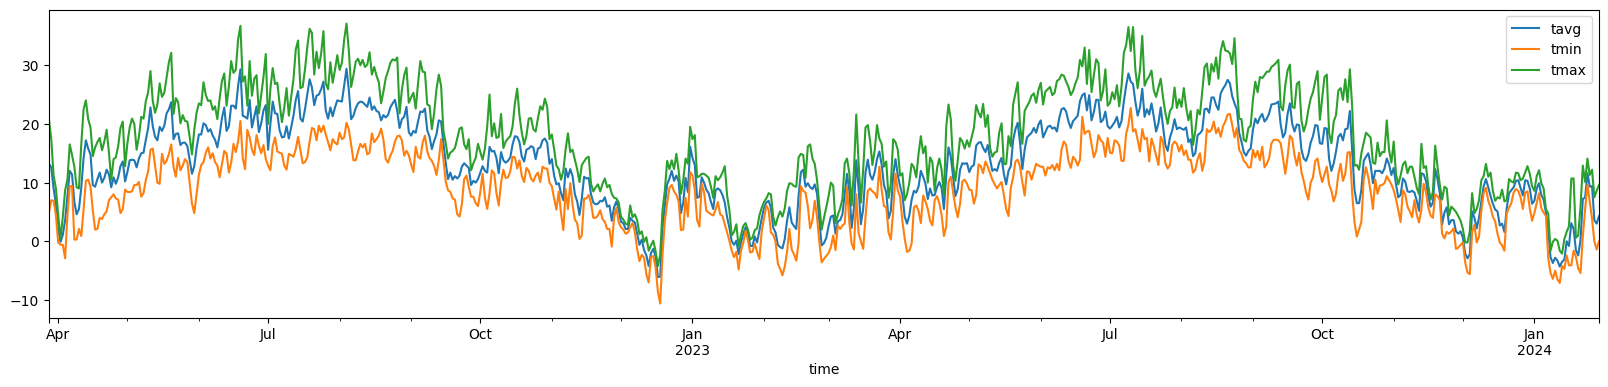

In [804]:
weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
plt.show()

<Axes: xlabel='timestemp'>

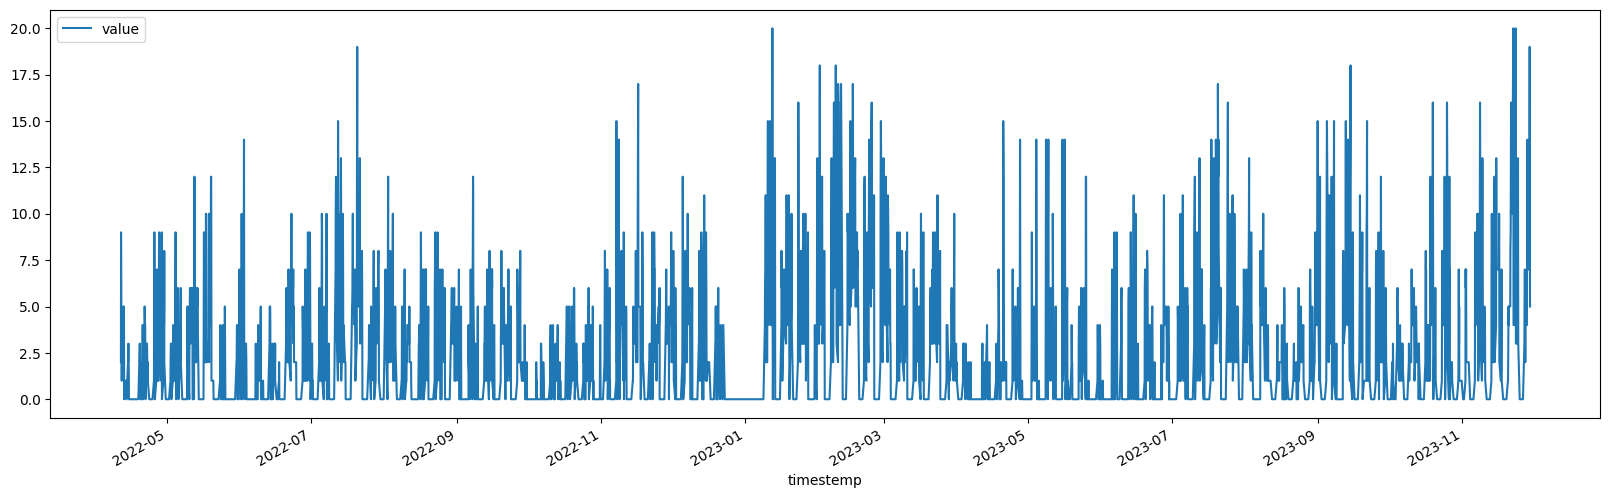

In [805]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

The data runs from May 2022 to November 2023. The graph shows the fluctuations in visitor numbers over time, with some periods having higher visitor numbers and others having lower or no visitor numbers, such as during the winter holidays.

In [806]:
visitor_data.describe()

,value,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),value (t-3),value (t-4),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
count,4783.000000,4783.000000,4783.000000,4783.00000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,...,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000,4783.000000
mean,2.421911,2.990174,0.284340,0.32281,0.053523,0.026761,2.420866,2.419820,2.417939,2.413966,...,2.339327,2.339954,2.339118,2.337863,2.336609,2.334936,2.333891,2.332845,2.331800,2.330755
std,3.340391,2.001178,0.451147,0.46760,0.225097,0.161402,3.340367,3.340342,3.339169,3.330729,...,3.219694,3.219920,3.219749,3.219101,3.218063,3.216158,3.215454,3.214749,3.214044,3.213338
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,4.000000,5.000000,1.000000,1.00000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,20.000000,6.000000,1.000000,1.00000,1.000000,1.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000


## 4. JOIN both dataframes (visitor_data + weather_data) and calculate correlations

In [807]:
# merge data frames
visitor_data_with_weather = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time"
)

visitor_data_with_weather.head()

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
1,2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2,2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
3,2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
4,2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0


In [808]:
visitor_data.set_index('timestemp', inplace=True)
visitor_data_with_weather.set_index('timestemp', inplace=True)
visitor_data_with_weather.head()

,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),value (t-3),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,2.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,9.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0


In [809]:
#calculate correlations between all features of data frame
data_corr = visitor_data_with_weather.corr()
data_corr

,value,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),value (t-3),value (t-4),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
value,1.000000,-0.413847,-0.457059,0.123916,-0.172433,-0.120241,0.756579,0.540086,0.382376,0.308671,...,-0.103441,-0.096834,-0.092813,0.012443,-0.022010,-0.021816,0.026588,-0.013010,0.023017,-0.066452
weekday,-0.413847,1.000000,0.790623,0.003391,-0.054540,0.016353,-0.392329,-0.363521,-0.328039,-0.285988,...,0.002924,0.007145,-0.006256,0.009955,0.043489,0.028722,-0.022200,-0.017266,0.011614,-0.013643
weekend,-0.457059,0.790623,1.000000,-0.006960,-0.051050,0.010351,-0.446596,-0.431971,-0.416359,-0.400519,...,-0.003857,-0.003740,-0.013080,-0.004833,0.041330,0.024208,-0.003549,-0.003433,0.054377,0.004177
exam_phase,0.123916,0.003391,-0.006960,1.000000,-0.164185,-0.114489,0.124669,0.126894,0.129337,0.132770,...,0.237332,0.245624,0.249659,-0.002974,-0.061206,0.001665,0.003103,0.057805,-0.060715,0.083467
holiday,-0.172433,-0.054540,-0.051050,-0.164185,1.000000,0.697317,-0.170135,-0.167003,-0.164145,-0.161488,...,-0.059962,-0.061423,-0.066261,-0.017363,-0.025988,0.072697,0.069806,0.097528,0.088855,-0.055036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wdir,-0.021816,0.028722,0.024208,0.001665,0.072697,0.013864,-0.020457,-0.018274,-0.014757,-0.009508,...,-0.045267,0.070677,-0.115333,0.033366,-0.035022,1.000000,0.245614,0.192334,-0.089786,-0.243659
wspd,0.026588,-0.022200,-0.003549,0.003103,0.069806,0.112650,0.024490,0.026395,0.029959,0.036862,...,-0.095551,-0.047586,-0.127332,0.060973,-0.007429,0.245614,1.000000,0.739003,-0.231961,-0.196088
wpgt,-0.013010,-0.017266,-0.003433,0.057805,0.097528,0.118859,-0.012372,-0.011677,-0.007882,-0.002579,...,0.082067,0.126510,0.065082,0.256570,-0.091038,0.192334,0.739003,1.000000,-0.326850,-0.132902
pres,0.023017,0.011614,0.054377,-0.060715,0.088855,0.073145,0.023133,0.023173,0.022739,0.022604,...,-0.097673,-0.158550,-0.057365,-0.301073,0.061742,-0.089786,-0.231961,-0.326850,1.000000,0.196425


In [810]:
data_corr_label = visitor_data_with_weather.iloc[:, :].corr()["value"]
data_corr_label

value         1.000000
weekday      -0.413847
weekend      -0.457059
exam_phase    0.123916
holiday      -0.172433
                ...   
wdir         -0.021816
wspd          0.026588
wpgt         -0.013010
pres          0.023017
tsun         -0.066452
Name: value, Length: 128, dtype: float64

The correlation matrix shows the correlation between the features.

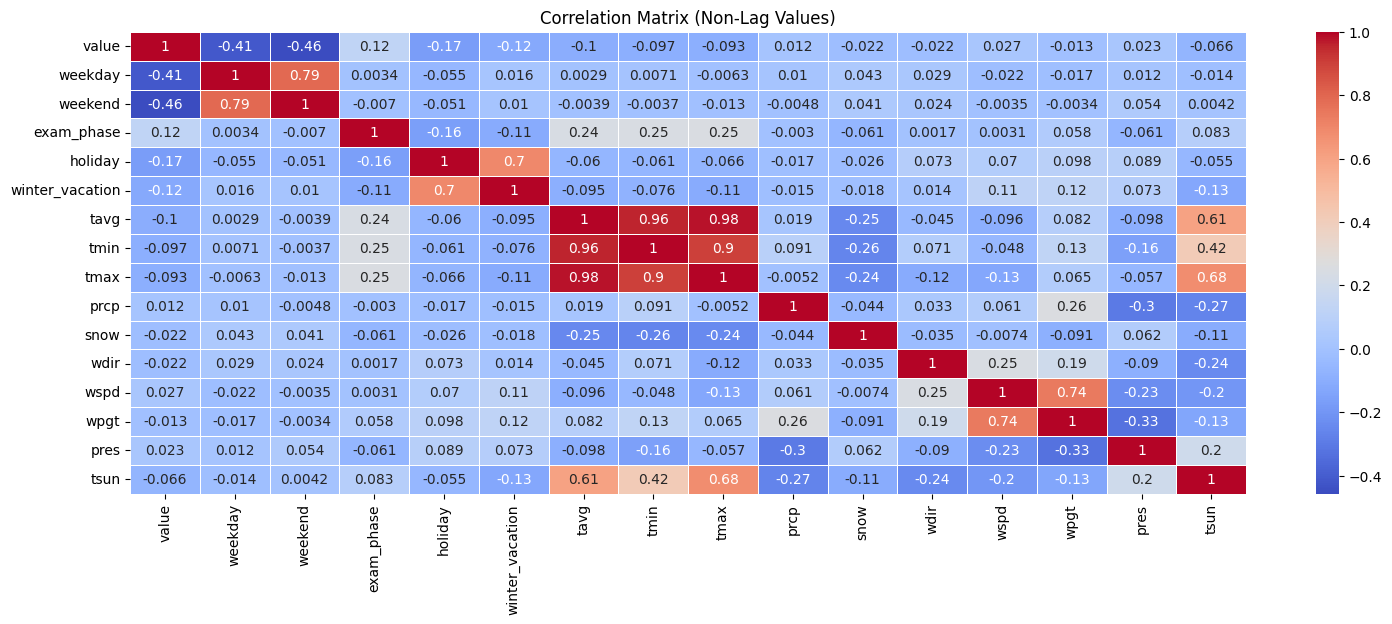

In [811]:
non_lag_columns = [col for col in data_corr.columns if "(t-" not in col]

data_corr_non_lag = data_corr[non_lag_columns].loc[non_lag_columns]

plt.figure(figsize=(18, 6))
sns.heatmap(data_corr_non_lag, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix (Non-Lag Values)')
plt.show()

The correlation between the visitor numbers and the weather data is is relatively low. The highest correlation of the weather data is the average temperature with a value of -0.1 (see figure below).

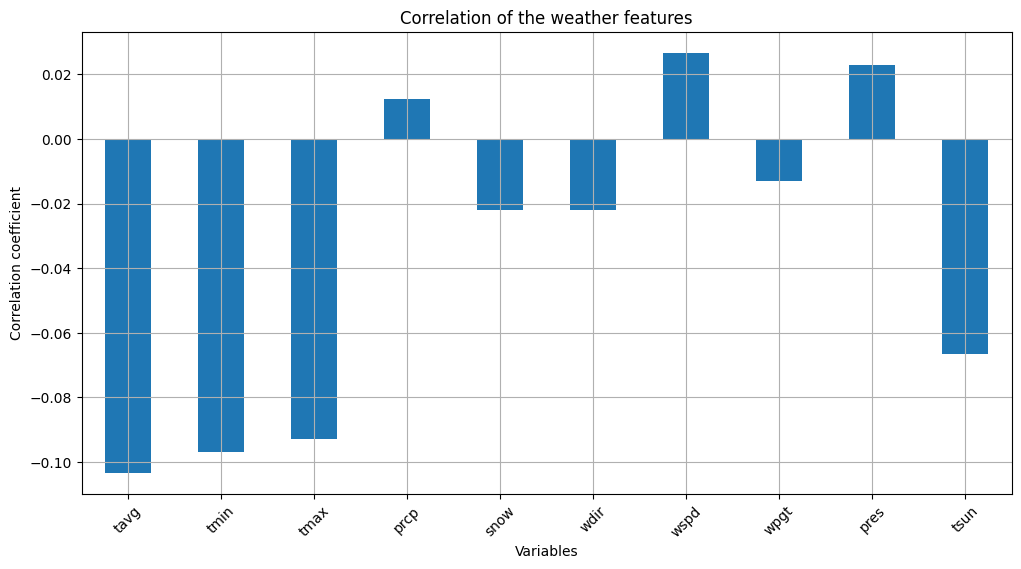

In [812]:
plt.figure(figsize=(12, 6))
data_corr_label["tavg":].plot(kind='bar')
plt.title('Correlation of the weather features')
plt.xlabel('Variables')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Weather data is removed from the data frame as it has a very low correlation.

In [813]:
# drop unnecessary features
droplist = ['date', 'winter_vacation', 'weekend']
visitor_data = visitor_data.drop(droplist, axis=1)

visitor_data.head()

,value,weekday,exam_phase,holiday,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 10:45:00,9.0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 13:45:00,5.0,0,0,0,9.0,2.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
2022-04-11 16:15:00,5.0,0,0,0,5.0,9.0,2.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
2022-04-11 17:45:00,1.0,0,0,0,5.0,5.0,9.0,2.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0


## 5. Prepare Data for Model

In [814]:
visitor_data.head()

,value,weekday,exam_phase,holiday,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),...,value (t-103),value (t-104),value (t-105),value (t-106),value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112)
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 10:45:00,9.0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2022-04-11 13:45:00,5.0,0,0,0,9.0,2.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0
2022-04-11 16:15:00,5.0,0,0,0,5.0,9.0,2.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0,2.0
2022-04-11 17:45:00,1.0,0,0,0,5.0,5.0,9.0,2.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,2.0,2.0


In [815]:
visitor_data.shape

(4783, 116)

In [816]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
new_visitor_data = scaler.fit_transform(visitor_data)

new_visitor_data

array([[0.1       , 0.        , 0.        , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.45      , 0.        , 0.        , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.25      , 0.        , 0.        , ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.45      , 0.33333333, 0.        , ..., 0.35      , 0.35      ,
        0.35      ],
       [0.25      , 0.33333333, 0.        , ..., 0.35      , 0.35      ,
        0.35      ],
       [0.25      , 0.33333333, 0.        , ..., 0.35      , 0.35      ,
        0.35      ]])

In [817]:
# Split into features and labels

data_features = new_visitor_data[:, 1:]
data_labels = new_visitor_data[:, 0]

data_features.shape, data_labels.shape

((4783, 115), (4783,))

In [818]:
data_labels

array([0.1 , 0.45, 0.25, ..., 0.45, 0.25, 0.25])

In [819]:
# Flip the data because of the order of the sequence
data_features = dc(np.flip(data_features, axis=1))
data_features

array([[0.1       , 0.1       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.1       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.1       , 0.1       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.35      , 0.35      , 0.35      , ..., 0.        , 0.        ,
        0.33333333],
       [0.35      , 0.35      , 0.35      , ..., 0.        , 0.        ,
        0.33333333],
       [0.35      , 0.35      , 0.35      , ..., 0.        , 0.        ,
        0.33333333]])

In [820]:
# Train test Split
split_index = int(len(data_features) * 0.8)

train_features = data_features[:split_index]
test_features = data_features[split_index:]

train_labels = data_labels[:split_index]
test_labels = data_labels[split_index:]

In [821]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((3826, 115), (3826,), (957, 115), (957,))

In [822]:
# Reshape the arrays into 3-dimeniosnal arrays.
# LSTM-Models requires a 3-dimensional input.
goback = len(visitor_data.columns) -1

train_features = train_features.reshape((-1, goback, 1))
test_features = test_features.reshape((-1, goback, 1))

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((3826, 115, 1), (957, 115, 1), (3826, 1), (957, 1))

In [823]:
# Turn the data into tensors
train_features = torch.tensor(train_features).float()
train_labels = torch.tensor(train_labels).float()

test_features = torch.tensor(test_features).float()
test_labels = torch.tensor(test_labels).float()

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

(torch.Size([3826, 115, 1]),
 torch.Size([957, 115, 1]),
 torch.Size([3826, 1]),
 torch.Size([957, 1]))

## 6. Dataset and DataLoader

In [824]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(train_features, train_labels)
test_dataset = TimeSeriesDataset(test_features, test_labels)

In [825]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x1ac8de1c950>,
 <__main__.TimeSeriesDataset at 0x1ac84b49490>)

With a lookback of 112 steps, we choose a relatively small batch size of 8 to avoid memory problems. With more memory available, the batch size could be increased to 16. The data set is divided into 80% training and 20% test data.

In [826]:
BS = 8

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

for x, y in train_loader:
    print(f"Input Batch Shape: {x.shape} - (batch size, Features, scalar label)")
    print(f"Label Batch Shape: {y.shape} - (batch size, label dimension)")
    break


Input Batch Shape: torch.Size([8, 115, 1]) - (batch size, Features, scalar label)
Label Batch Shape: torch.Size([8, 1]) - (batch size, label dimension)


## 7. Build Model

### 7.1. LSTM Model Architecture

An LSTM is specifically designed to recognise and learn from long-term dependencies. The problem with simple recurrent neural networks is that they do not retain information over a long period of time, the gradient of the loss function tends to become smaller or larger as it propagates back through many layers. The problem is that the network can hardly learn due to the low weights in the earlier layers, or the network becomes unstable.

The most important thing about the LSTM is the vertical red line in the diagram. This is the cell state that memorises the patterns of the students.

Steps:
- The first layer decides which information from the cell state should be discarded. The sigmoid function outputs values between 0 and 1, where 0 means no information is passed and 1 means all information is passed. Initially the LSTM doesn't have any previous cell state so it passes a vector of zeros.

- The next layer decides what new information to add to the cell state. The next layer, which is also a sigmoid function, determines which values in the cell state are updated. At the same time, the tanh layer generates a vector of new candidate values that could potentially be added to the state. These two aspects work together to prepare an update of the cell state.

- In the last layer, the LSTM decides what to output, which is based on the filtered cell state. A sigmoid layer determines which parts of the cell state are output. The cell state is then passed through a tanh function, which scales the values between -1 and 1, and multiplied by the output.

<img src="./img/lstm.png" width="700px">

Quelle: https://griesshaber.pages.mi.hdm-stuttgart.de/nlp/07neuralnetworks/02RecurrentNeuralNetworks.html

In [827]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size=self.input_size, # input size
                            hidden_size=self.hidden_layer_size, # hidden layer
                            num_layers=self.num_layers #stacked layers
                            )
        self.linear = nn.Linear(self.hidden_layer_size, self.output_size)
        
        self.hidden_cell = (
            torch.zeros(self.num_layers, 1, self.hidden_layer_size),
            torch.zeros(self.num_layers, 1, self.hidden_layer_size),
        )

    def forward(self, input_seq):
        # reshape the input sequence for LSTM
        input_seq_reshaped = input_seq.view(len(input_seq), 1, -1) 

        lstm_out, self.hidden_cell = self.lstm(input_seq_reshaped, self.hidden_cell)

        lstm_out_reshaped = lstm_out.view(len(input_seq), -1)

        predictions = self.linear(lstm_out_reshaped)

        return predictions

### 7.2. Training

* The output_size is set to 1, as the model should predict a regression
* By trial and error, we determined the dimension of the hidden state and the learning_rate
* We use a stacked LSTM with 2 layers to allow for greater model complexity
* We use the Adam optimiser because it dynamically adjusts learning rates and often converges more quickly

In [828]:
loss_list = []
input_size = goback
hidden_layer_size = 100
output_size = 1
num_layers = 2
learning_rate = 0.001

model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [829]:
summary(model, input_size=(8, 115))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [8, 1]                    --
├─LSTM: 1-1                              [8, 1, 100]               167,600
├─Linear: 1-2                            [8, 1]                    101
Total params: 167,701
Trainable params: 167,701
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.67
Estimated Total Size (MB): 0.68

In [830]:
epochs = 3

print(f"Using: {device} for training")

for epoch in range(epochs):
    model.train()
    
    # reset the hidden state at each loop
    model.hidden_cell = (
        torch.zeros(num_layers, 1, model.hidden_layer_size),
        torch.zeros(num_layers, 1, model.hidden_layer_size),
    )

    for i, (x_batch, y_batch) in enumerate(train_loader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # reset the gradients
        optimizer.zero_grad()

        # prevent backpropagating of the dataset
        model.hidden_cell = (
            model.hidden_cell[0].detach(),
            model.hidden_cell[1].detach(),
        )

        # forward pass
        y_pred = model(x_batch.float())

        # compute loss
        loss = loss_function(y_pred, y_batch.float())
        loss_list.append(loss.detach().numpy())

        # backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

print("Training complete")

Using: cpu for training


Epoch 1/3 Loss: 0.0026510173920542
Epoch 2/3 Loss: 0.00037759964470751584
Epoch 3/3 Loss: 0.00022916655871085823
Training complete


### 7.3. Validation

#### MSE, Root MSE, MAE

In [831]:
total_loss = 0
count = 0
actuals = []
predictions = []
test_loss = []

with torch.no_grad():
    model.train(False)
    for x_batch, y_batch in test_loader:
        
        y_pred = model(x_batch.float())

        predictions.extend(y_pred.view(-1).tolist())
        actuals.extend(y_batch.view(-1).tolist())

        loss = loss_function(y_pred, y_batch.float())
        total_loss += loss.item()
        test_loss.append(loss.item())
        count += 1

mse = total_loss / count
rmse = mse ** 0.5
actuals_np = np.array(actuals)
predictions_np = np.array(predictions)

mae = mean_absolute_error(actuals_np, predictions_np)

print(f"Mean Squared Error on test data: {mse}")
print(f"Root Mean Squared Error on test data: {rmse}")
print(f"Mean Absolute Error on test data: {mae}")

Mean Squared Error on test data: 0.01501468184578698
Root Mean Squared Error on test data: 0.12253441086399763
Mean Absolute Error on test data: 0.09540828233322006


Compared to the average number of visitors (including weekends and public holidays), the error metrics appear to be relatively low. In other words, the model's predictions are relatively accurate compared to the average number of visitors.

In [832]:
average_visitors = visitor_data['value'].mean()
print(f'Average Visitors: {round(average_visitors, 2)}')

Average Visitors: 2.42


### 7.4. Evaluation

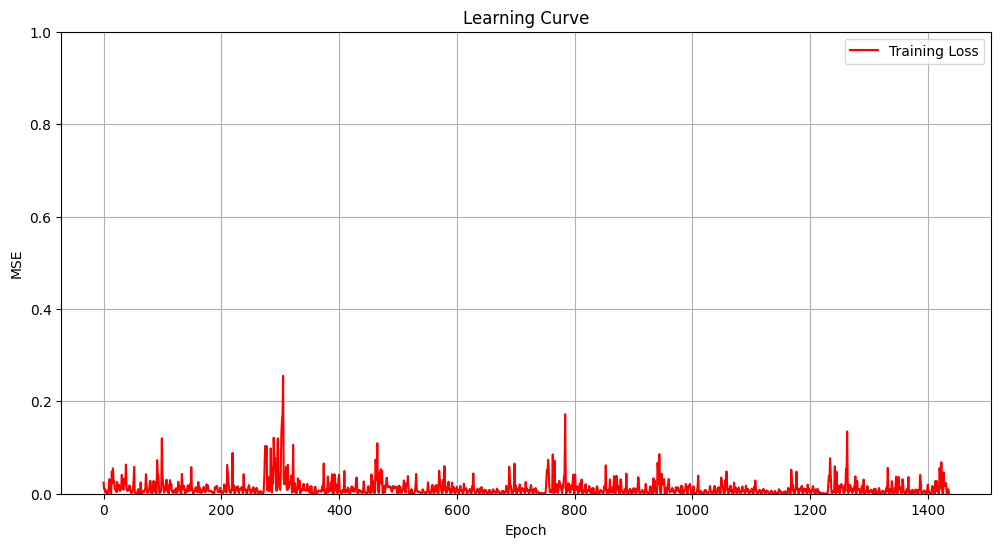

In [833]:
plt.figure(figsize=(12,6))
plt.plot(range(len(loss_list)),loss_list,"r",label="Training Loss")
plt.axis([None, None, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.title("Learning Curve")
plt.show()

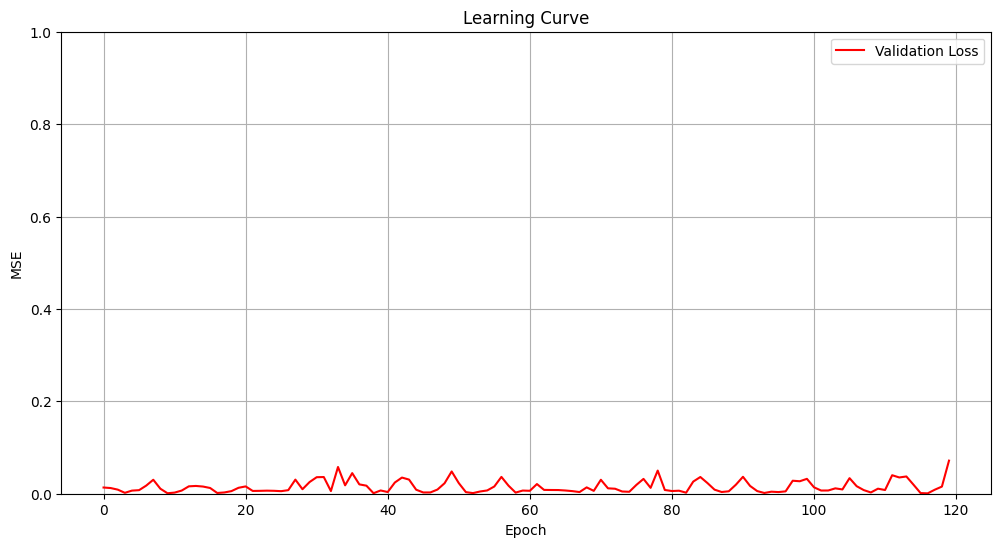

In [834]:
plt.figure(figsize=(12,6))
plt.plot(range(len(test_loss)),test_loss,"r",label="Validation Loss")
plt.axis([None, None, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.title("Learning Curve")
plt.show()

In [835]:
test_predictions = model(test_features).detach().numpy().flatten()

dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
# test_predictions

In [836]:
dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_labels.flatten()
dummies = scaler.inverse_transform(dummies)

new_test_labels = dc(dummies[:, 0])
# new_test_labels

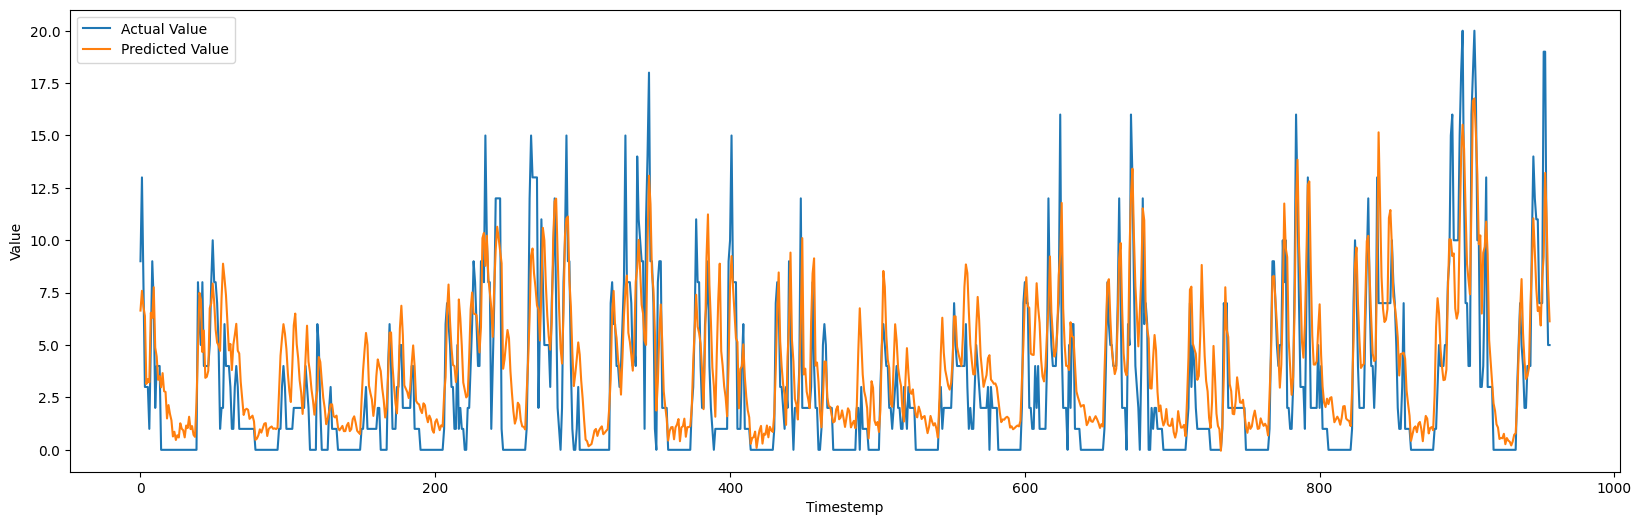

In [837]:
plt.figure(figsize=(20, 6))
plt.plot(new_test_labels, label='Actual Value')
plt.plot(test_predictions, label='Predicted Value')
plt.xlabel('Timestemp')
plt.ylabel('Value')
plt.legend()
plt.show()

## 8. Suggestions for improvement:

After training, validation and evaluation, we came up with further ideas and suggestions for improvements that could improve the model's prediction values.

- **New feature: Opening hours: open = 1; closed = 0**

    In the visitor statistics (our data), the time periods are divided into eight sections: `09:30`, `10:45`, `13:45`, `16:15`, `17:45`, `18:00`, `18:30` and `18:45`. However, the opening hours of the library are not the same every day (Mon. - Thurs. 09:00-19:00; Fri. 09:00 - 17:00). This results in predictions > 0 on Friday, even though the library is closed. By adding the new feature, the model could learn that there can be no visitors at this time on Fridays. This would perhaps also improve the overall metric somewhat.

- **Conduct a survey in the library to find out the reasons for coming/not coming (empirical)**

    The second idea is to conduct a survey in the library to find out when and why visitors come to the library. Based on the answers, new features could be added and current features could be removed. However, the idea would go in the direction of an "empirical study" and would be an idea for a bachelor thesis, but would go beyond the scope of this project.

## 9. Learnings

- **Dealing with PyTorch**: 

    The lecture and project deepened our understanding of using PyTorch as a library for programming DeepLearning networks.

- **Building an LSTM**: 

    Through the hands-on project, we got a deep understanding of how an LSTM works and understood the architecture.

- **Data science process (ETL)**: 

    Due to the fact that the data is not finished data, but self-collected data, we were able to experience the whole ETL process. Etract, Transform, Load. We extracted the data from the analogue statistics, processed this data and finally saved it to create an LSTM model.

- **Preparing data for a model**: 

    Through the preprocessing and preparation steps, we realised how to prepare data for an AI model, or for an LSTM model.

- **Understanding AI sources**: 

    By using an LSTM model, without prior knowledge in this area, we had to deal with a lot of literature and tutorials in the field of DeepLeanring and LSTM and got a good understanding of hot to evaluate these sources and extract the content for our own ideas/applications.

- **Practical experience**: 

    Through this practical project we have gained practical experience in the field of DeepLearning, which was previously only based on theoretical knowledge.

- **Finding an idea for a model/implementing an idea**: 

    Through the practical project, we are now able to implement ideas using a DeepLeanring, or ML model.

# Quellen

**Recherche Quelen:**
- https://griesshaber.pages.mi.hdm-stuttgart.de/nlp/07neuralnetworks/02RecurrentNeuralNetworks.html
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://databasecamp.de/en/ml/lstms
